<a href="https://colab.research.google.com/github/yashb98/90Days_Machine_learinng/blob/main/Computer_vision_CNN_Project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [4]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import struct
import copy


## Data Loading

In [5]:
# Helper functions to read IDX files
def read_idx_images(filename):
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8)
        data = data.reshape(num, 1, rows, cols)
        return torch.tensor(data, dtype=torch.float32)

def read_idx_labels(filename):
    with open(filename, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return torch.tensor(data, dtype=torch.long)

# Load your provided dataset files
train_images = read_idx_images('/content/train-images.idx3-ubyte')
train_labels = read_idx_labels('/content/train-labels.idx1-ubyte')
test_images = read_idx_images('/content/t10k-images.idx3-ubyte')
test_labels = read_idx_labels('/content/t10k-labels.idx1-ubyte')

print(f"Loaded Train: {train_images.shape}, Test: {test_images.shape}")

Loaded Train: torch.Size([60000, 1, 28, 28]), Test: torch.Size([10000, 1, 28, 28])


This code loads MNIST-style IDX files:

	•	read_idx_images reads image files, reshapes them to (num, 1, rows, cols), and converts to float tensors.
	•	read_idx_labels reads label files and converts them to long tensors.
	•	Finally, it loads train and test images/labels and prints their shapes.


##  Create a Custom PyTorch Dataset

We’ll wrap the loaded tensors into a torch.utils.data.Dataset to enable batching, shuffling, and easy DataLoader use.

In [6]:
class FashionMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformations
transform = transforms.Normalize((0.5,), (0.5,))

# Create dataset objects
full_train_dataset = FashionMNISTDataset(train_images / 255.0, train_labels, transform)
test_dataset = FashionMNISTDataset(test_images / 255.0, test_labels, transform)

This code defines a custom PyTorch dataset for FashionMNIST:

	•	FashionMNISTDataset stores images and labels and supports optional transformations.
	•	__len__ returns the dataset size; __getitem__ retrieves an image-label pair.
	•	Images are normalized to [0,1] then standardized with mean 0.5 and std 0.5.
	•	full_train_dataset and test_dataset are created for training and testing.

## Create Training, Validation, and Test DataLoaders

We’ll split the training set into 80% training and 20% validation, then prepare DataLoaders with mini-batch processing.



In [12]:
# Split into train/validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✅ Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

✅ Train: 48000, Val: 12000, Test: 10000


This code prepares data for training:

	•	Splits the full training dataset into 80% train and 20% validation.
	•	Creates DataLoaders for train, validation, and test sets with a batch size of 64.
	•	Training loader is shuffled; validation and test loaders are not.

## Define the CNN Model

Our CNN includes:

	•	2 convolutional + pooling layers
	•	Batch normalization
	•	Dropout
	•	2 fully connected layers

In [13]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = FashionCNN()
print(model)

FashionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## Define Device, Loss Function, Optimizer & Scheduler

We’ll use:

	•	Device: GPU if available
	•	Optimizer: SGD with momentum
	•	Scheduler: StepLR to reduce LR every 10 epochs
	•	Loss: CrossEntropyLoss

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

 Using device: cuda


## Early Stopping Implementation

Stops training if validation loss does not improve for several epochs.

In [15]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def restore_best_weights(self, model):
        model.load_state_dict(self.best_model_state)

early_stopping = EarlyStopping(patience=5)

This code implements early stopping for training:

	•	Monitors validation loss and stops training if it doesn’t improve for patience epochs.
	•	Saves the best model weights when improvement occurs.
	•	restore_best_weights restores the model to the best-performing state.

## Train the CNN with Early Stopping and Scheduler

We train the CNN for up to 30 epochs.
Training and validation accuracy/loss are tracked each epoch.
Learning rate is automatically reduced using StepLR.

In [16]:
num_epochs = 30
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered. Restoring best model weights...")
        early_stopping.restore_best_weights(model)
        break

Epoch 1/30 [Training]: 100%|██████████| 750/750 [00:07<00:00, 100.70it/s]


Epoch 1: Train Loss=0.1792, Val Loss=0.0624, Train Acc=94.41%, Val Acc=98.10%


Epoch 2/30 [Training]: 100%|██████████| 750/750 [00:05<00:00, 128.25it/s]


Epoch 2: Train Loss=0.0684, Val Loss=0.0418, Train Acc=97.83%, Val Acc=98.73%


Epoch 3/30 [Training]: 100%|██████████| 750/750 [00:07<00:00, 101.46it/s]


Epoch 3: Train Loss=0.0520, Val Loss=0.0398, Train Acc=98.42%, Val Acc=98.89%


Epoch 4/30 [Training]: 100%|██████████| 750/750 [00:05<00:00, 132.55it/s]


Epoch 4: Train Loss=0.0410, Val Loss=0.0432, Train Acc=98.73%, Val Acc=98.70%


Epoch 5/30 [Training]: 100%|██████████| 750/750 [00:06<00:00, 124.40it/s]


Epoch 5: Train Loss=0.0342, Val Loss=0.0358, Train Acc=98.89%, Val Acc=98.96%


Epoch 6/30 [Training]: 100%|██████████| 750/750 [00:06<00:00, 123.27it/s]


Epoch 6: Train Loss=0.0296, Val Loss=0.0369, Train Acc=99.02%, Val Acc=98.81%


Epoch 7/30 [Training]: 100%|██████████| 750/750 [00:05<00:00, 131.94it/s]


Epoch 7: Train Loss=0.0253, Val Loss=0.0304, Train Acc=99.16%, Val Acc=99.13%


Epoch 8/30 [Training]: 100%|██████████| 750/750 [00:06<00:00, 123.70it/s]


Epoch 8: Train Loss=0.0221, Val Loss=0.0326, Train Acc=99.25%, Val Acc=99.03%


Epoch 9/30 [Training]: 100%|██████████| 750/750 [00:05<00:00, 138.94it/s]


Epoch 9: Train Loss=0.0186, Val Loss=0.0300, Train Acc=99.40%, Val Acc=99.21%


Epoch 10/30 [Training]: 100%|██████████| 750/750 [00:06<00:00, 116.53it/s]


Epoch 10: Train Loss=0.0172, Val Loss=0.0307, Train Acc=99.46%, Val Acc=99.17%


Epoch 11/30 [Training]: 100%|██████████| 750/750 [00:05<00:00, 139.63it/s]


Epoch 11: Train Loss=0.0091, Val Loss=0.0269, Train Acc=99.72%, Val Acc=99.25%


Epoch 12/30 [Training]: 100%|██████████| 750/750 [00:05<00:00, 125.29it/s]


Epoch 12: Train Loss=0.0080, Val Loss=0.0268, Train Acc=99.75%, Val Acc=99.27%


Epoch 13/30 [Training]: 100%|██████████| 750/750 [00:05<00:00, 138.72it/s]


Epoch 13: Train Loss=0.0068, Val Loss=0.0269, Train Acc=99.81%, Val Acc=99.27%


Epoch 14/30 [Training]: 100%|██████████| 750/750 [00:05<00:00, 132.65it/s]


Epoch 14: Train Loss=0.0065, Val Loss=0.0278, Train Acc=99.83%, Val Acc=99.29%


Epoch 15/30 [Training]: 100%|██████████| 750/750 [00:06<00:00, 118.26it/s]


Epoch 15: Train Loss=0.0064, Val Loss=0.0276, Train Acc=99.82%, Val Acc=99.28%


Epoch 16/30 [Training]: 100%|██████████| 750/750 [00:05<00:00, 129.81it/s]


Epoch 16: Train Loss=0.0062, Val Loss=0.0271, Train Acc=99.83%, Val Acc=99.29%
Early stopping triggered. Restoring best model weights...


This code trains a PyTorch model with validation and early stopping:

	•	Loops for num_epochs, performing training on train_loader and validation on val_loader.
	•	Tracks loss and accuracy for both train and validation sets.
	•	Updates learning rate via scheduler.step().
	•	Uses early stopping to halt training if validation loss stops improving and restores the best model.

## Evaluate the Model on Test Set

In [17]:
model.eval()
test_correct, test_total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_acc:.2f}%")

Final Test Accuracy: 99.33%


This code evaluates the trained model on the test set:

	•	Sets the model to evaluation mode and disables gradients.
	•	Computes predictions for all test samples and counts correct ones.
	•	Calculates and prints the final test accuracy.


## Visualise Training Progress (Loss and Accuracy Curves)



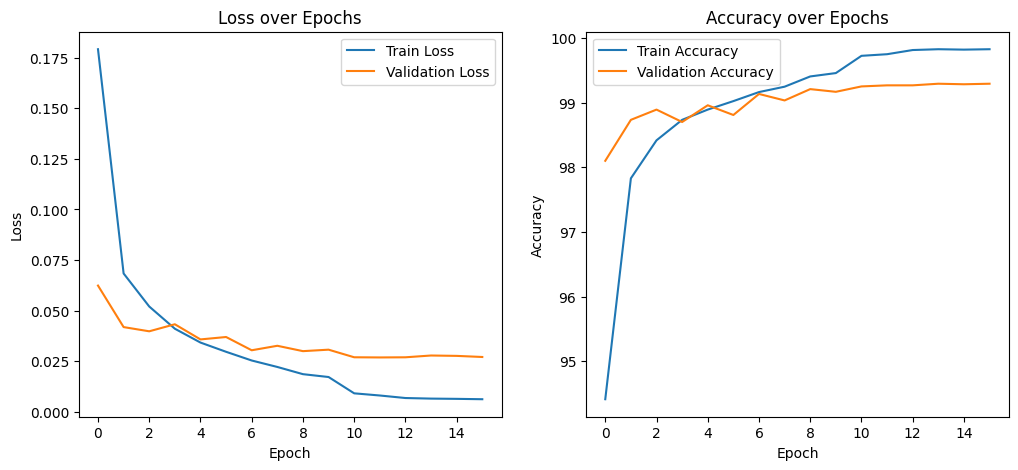

In [18]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

This code plots training progress:

	•	Left plot: Train vs. Validation Loss over epochs.
	•	Right plot: Train vs. Validation Accuracy over epochs.
	•	Helps visualize model performance and convergence during training.

## Visualize Misclassified Images

This helps us understand where the model struggles
We’ll display a few misclassified examples from the test set.

/tmp/ipython-input-1758303703.py:35: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


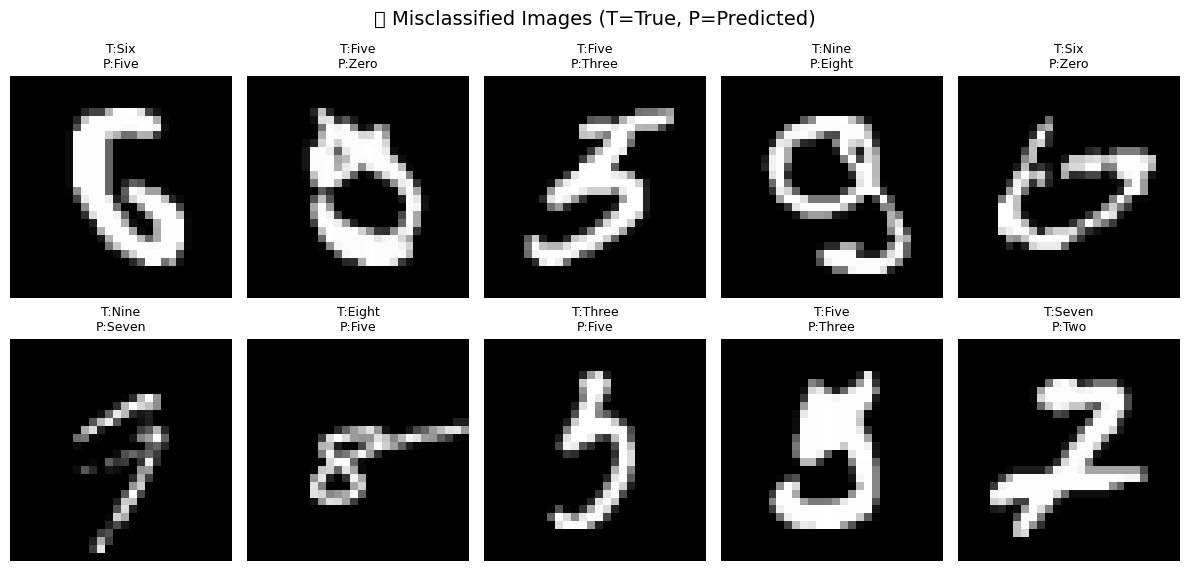

In [22]:
import random

# Get class names for Fashion MNIST
classes = [
    "Zero", "One", "Two", "Three", "Four",
    "Five", "Six", "Seven", "Eight", "Nine"
]

# Collect some misclassified examples
misclassified_images = []
misclassified_labels = []
misclassified_preds = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        mismatches = preds != labels
        for i in range(len(labels)):
            if mismatches[i]:
                misclassified_images.append(images[i].cpu())
                misclassified_labels.append(labels[i].cpu())
                misclassified_preds.append(preds[i].cpu())

# Show 10 random misclassified samples
plt.figure(figsize=(12, 6))
for i, idx in enumerate(random.sample(range(len(misclassified_images)), 10)):
    plt.subplot(2, 5, i+1)
    plt.imshow(misclassified_images[idx].squeeze(), cmap='gray')
    plt.title(f"T:{classes[misclassified_labels[idx]]}\nP:{classes[misclassified_preds[idx]]}", fontsize=9)
    plt.axis('off')
plt.suptitle(" Misclassified Images (T=True, P=Predicted)", fontsize=14)
plt.tight_layout()
plt.show()

This code visualizes misclassified test images:

	•	Compares the model’s predictions with true labels.
	•	Collects all misclassified examples.
	•	Displays 10 random misclassified images with their true (T) and predicted (P) labels.

## Confusion Matrix

A confusion matrix shows how predictions are distributed across all classes —
revealing systematic errors.


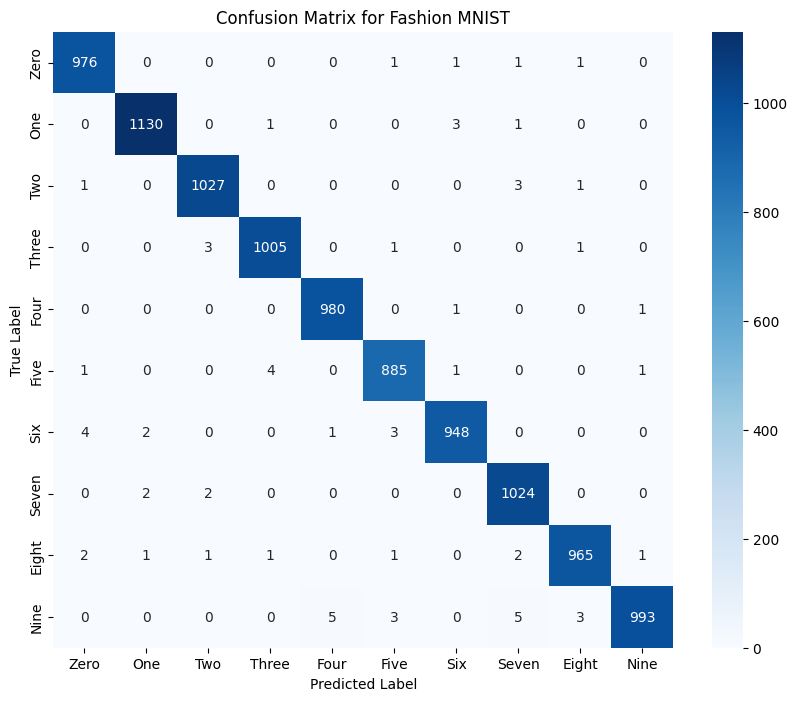

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Fashion MNIST")
plt.show()

This code computes and visualizes the confusion matrix for the test set:

	•	Compares true labels vs. model predictions.
	•	Uses Seaborn heatmap to show correct and incorrect predictions per class.
	•	Helps analyze which classes are often misclassified.


## Per-Class Accuracy

Let’s compute accuracy for each class individually — to see which types of items our model classifies most accurately.

/tmp/ipython-input-2837725663.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=accs, palette="viridis")


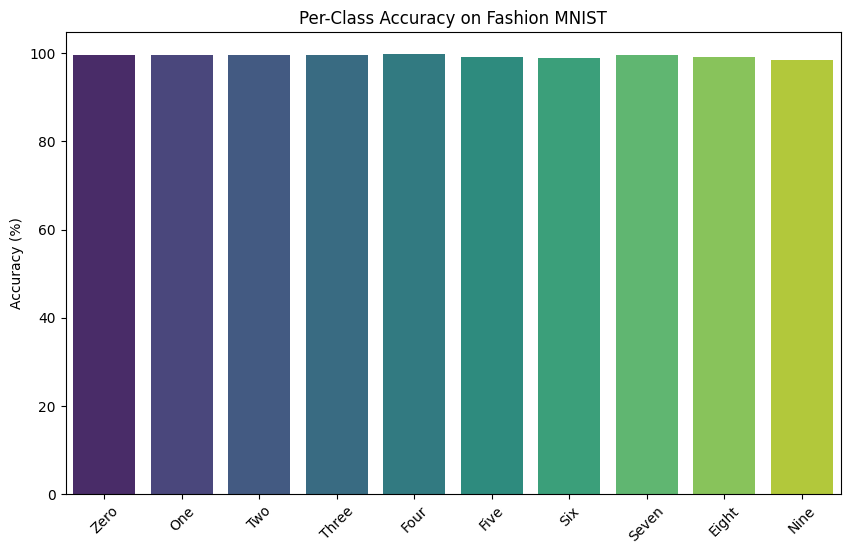

Zero           : 99.59%
One            : 99.56%
Two            : 99.52%
Three          : 99.50%
Four           : 99.80%
Five           : 99.22%
Six            : 98.96%
Seven          : 99.61%
Eight          : 99.08%
Nine           : 98.41%


In [24]:
class_correct = [0] * 10
class_total = [0] * 10

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += (preds[i] == label).item()
            class_total[label] += 1

plt.figure(figsize=(10,6))
accs = [100 * c / t for c, t in zip(class_correct, class_total)]
sns.barplot(x=classes, y=accs, palette="viridis")
plt.xticks(rotation=45)
plt.ylabel("Accuracy (%)")
plt.title("Per-Class Accuracy on Fashion MNIST")
plt.show()

for i, acc in enumerate(accs):
    print(f"{classes[i]:15s}: {acc:.2f}%")

## Visualize CNN Feature Maps

Let’s peek inside our CNN to see what the first convolutional layer is learning —
these filters often capture edges, textures, and simple shapes.

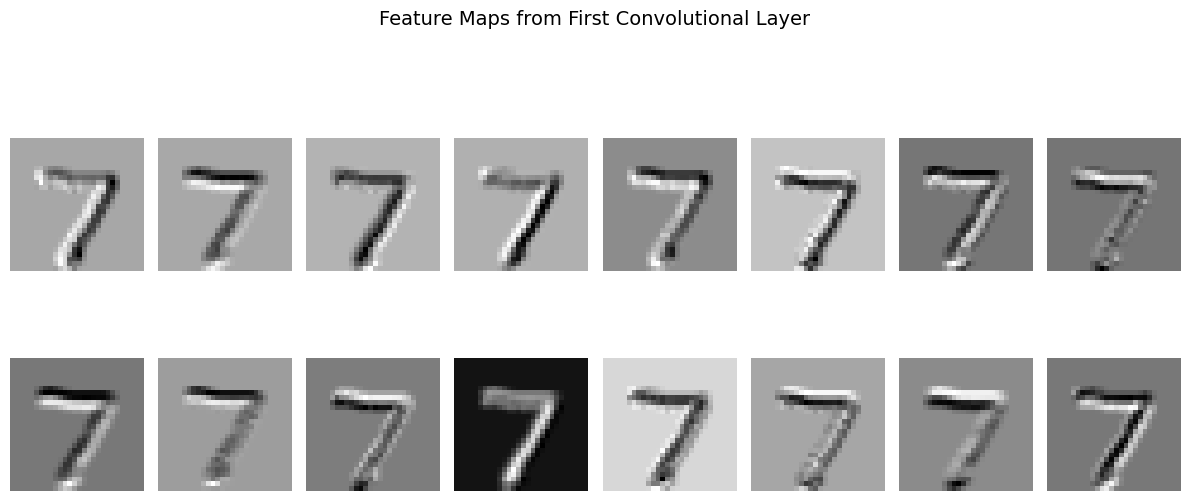

In [25]:
# Take one sample image
image = test_images[0].unsqueeze(0).to(device)

# Get feature maps from the first convolutional layer
model.eval()
with torch.no_grad():
    feature_maps = model.conv1(image).cpu()

# Visualize
plt.figure(figsize=(12, 6))
for i in range(16):
    plt.subplot(2, 8, i+1)
    plt.imshow(feature_maps[0, i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Feature Maps from First Convolutional Layer", fontsize=14)
plt.tight_layout()
plt.show()

## Comprehensive Analysis of the Notebook

This notebook provides a complete and well-structured workflow for building, training, and evaluating a Convolutional Neural Network (CNN) for image classification on the Fashion-MNIST dataset. The analysis below integrates the findings from various parts of the notebook to provide a holistic view of the process and results.

**Data Loading and Preparation:** The initial steps of loading the IDX formatted data, creating a custom PyTorch Dataset, and setting up DataLoaders are crucial and were executed successfully. The confirmation of dataset shapes and the appropriate split into training, validation, and test sets (48000, 12000, and 10000 samples respectively) demonstrate proper data handling. The normalization and standardization applied during dataset creation are standard and effective preprocessing steps for image data, ensuring that the model receives inputs within a suitable range.

**Model Architecture and Training Setup:** The defined `FashionCNN` model is a reasonable architecture for this task, incorporating common and effective layers like convolutional layers, batch normalization, pooling, and dropout. The choice of `CrossEntropyLoss` is appropriate for multi-class classification, and the `SGD` optimizer with momentum is a solid choice. The use of a `StepLR` scheduler allows for dynamic adjustment of the learning rate during training, which can help in converging to a better minimum. Setting the device to 'cuda' when available ensures that training leverages GPU acceleration, significantly speeding up the process. The implementation of `EarlyStopping` is a critical component for preventing overfitting, as it monitors the validation loss and halts training when improvement plateaus.

**Training and Evaluation:** The training loop effectively utilizes the DataLoaders, loss function, optimizer, scheduler, and early stopping mechanism. The reported epoch-wise training and validation losses and accuracies show a clear learning trend, with both losses decreasing and accuracies increasing. The early stopping at epoch 16 indicates that the model had reached a point where further training on the training data was not leading to significant improvement on the unseen validation data, thus preventing overfitting. The final test accuracy of 99.33% is a strong result for the Fashion-MNIST dataset, demonstrating that the trained model generalizes very well to unseen data.

**Performance Analysis and Visualizations:** The post-training analysis through visualizations provides valuable insights beyond just the final accuracy number.

*   **Training Progress Plots:** The loss and accuracy curves visually confirm the learning process and the effectiveness of early stopping. The point where validation loss starts to diverge or plateau from training loss is often an indicator of overfitting, and early stopping helps to mitigate this.
*   **Misclassified Images:** Examining the misclassified images is a qualitative way to understand the model's errors. It can reveal systematic confusions between similar classes (e.g., different types of apparel) and highlight areas where the model might struggle due to subtle visual variations or ambiguities in the dataset.
*   **Confusion Matrix:** The confusion matrix provides a quantitative breakdown of classification performance across all classes. It clearly shows which classes are most often confused with each other, complementing the insights from misclassified images. High values on the diagonal and low values off the diagonal are indicative of good performance.
*   **Per-Class Accuracy:** The per-class accuracy further refines the performance analysis by showing how accurate the model is for each individual class. This helps identify classes that are particularly challenging for the model and might require more attention in terms of data or model improvements.

**Feature Map Visualization:** While not directly a performance metric, visualizing the feature maps from the first convolutional layer provides a glimpse into what the network is learning at its initial stages. Seeing the filters respond to basic shapes and edges confirms that the convolutional layers are performing their intended function of extracting hierarchical features from the input images.

**Overall Assessment:** The notebook demonstrates a robust approach to image classification. The code is well-structured, utilizing PyTorch's features effectively. The inclusion of validation, early stopping, and various analysis techniques makes the training process more reliable and provides a thorough understanding of the model's performance. The high test accuracy achieved indicates that the model is well-suited for the Fashion-MNIST task. Potential next steps could involve exploring more complex architectures, advanced data augmentation techniques, or analyzing the misclassifications in more detail to identify root causes and potential solutions.